In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Importing files and defining dimension of image

width=256
height=256
channels=3

import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, get_data, shuffling

seed=42
np.random.seed=seed

In [5]:
#Defining path and getting ids of images
train_path='Preprocessed/Train/Image'
train_mask_path='Preprocessed/Train/Mask'
test_path='Preprocessed/Test/Image'
test_mask_path='Preprocessed/Test/Mask'

train_ids, train_mask_ids, test_ids, test_mask_ids = load_path(train_path, train_mask_path, test_path, test_mask_path)

In [6]:
#loding train and test images and randomly shuffling it
X_train, Y_train = get_data(train_path, train_mask_path, train_ids, train_mask_ids, height, width)
X_test, Y_test = get_data(test_path, test_mask_path, test_ids, test_mask_ids, height, width)
X_train, Y_train = shuffling(X_train, Y_train)
X_test, Y_test = shuffling(X_test, Y_test)

100%|██████████| 20/20 [00:00<00:00, 54.06it/s]


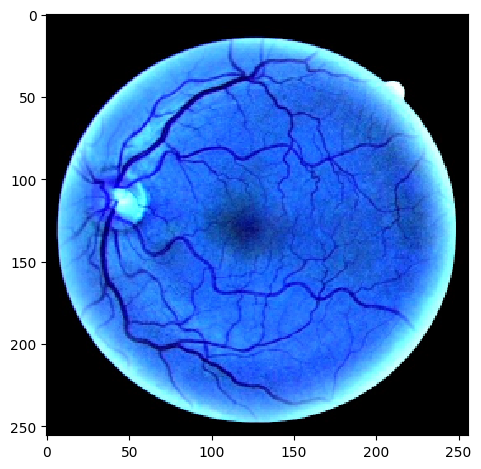

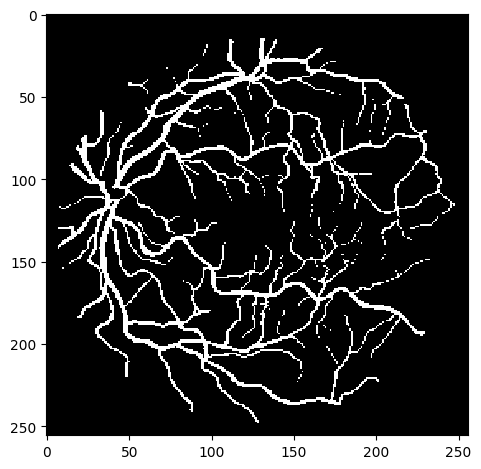

In [7]:
#testing train
img_x=random.randint(0, len(train_ids))
imshow(X_train[img_x])
plt.show()
imshow(Y_train[img_x])
plt.show()

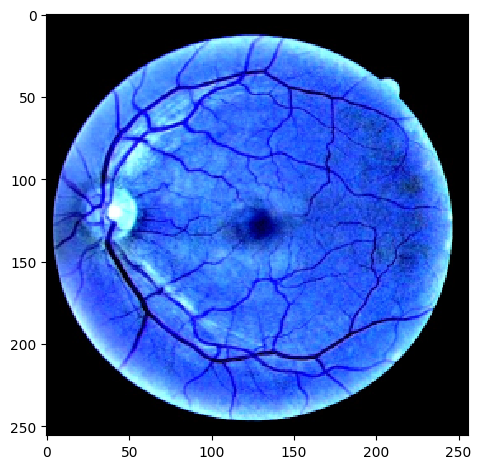

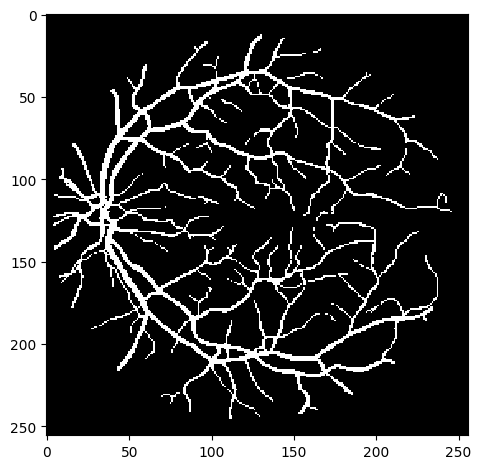

In [8]:
#testing test
img_x=random.randint(0, len(test_ids))
imshow(X_test[img_x])
plt.show()
imshow(Y_test[img_x])
plt.show()

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from Metrics import dice_coef, dice_loss, iou

In [25]:
#Defining parameters
batch_size = 4
lr = 1e-4
num_epochs = 200
# model_path = os.path.join('vggog.h5')
# csv_path = os.path.join('vggog.csv')

In [26]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [27]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x

In [28]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [29]:
def build_vgg16_unet(input_shape):
    inputs = Input(input_shape)
    
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    vgg16.trainable = False
    
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """ 
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")  
    return model

In [30]:
# input_shape = (height, width, 3)
# model = build_vgg16_unet(input_shape)
model.compile(optimizer=Adam(lr), loss=dice_loss, metrics=[dice_coef, iou, Accuracy(), Recall(), Precision()])
model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
________________________________________________________________________________________

In [31]:
#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose=1,save_best_only=True)

callbacks=[
#     ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
#     CSVLogger(csv_path),
]

results=model.fit(X_train, Y_train, validation_split = 0.05, batch_size = batch_size, epochs = 100, callbacks=callbacks)

Epoch 1/100
18/18 [==============================] - 8s 456ms/step - loss: 0.0738 - dice_coef: 0.9266 - iou: 0.8637 - accuracy: 0.0597 - recall_1: 0.8945 - precision_1: 0.9612 - val_loss: 0.2197 - val_dice_coef: 0.7803 - val_iou: 0.6398 - val_accuracy: 0.0539 - val_recall_1: 0.7293 - val_precision_1: 0.8396
Epoch 2/100
18/18 [==============================] - 4s 213ms/step - loss: 0.0699 - dice_coef: 0.9290 - iou: 0.8678 - accuracy: 0.0614 - recall_1: 0.9003 - precision_1: 0.9637 - val_loss: 0.2235 - val_dice_coef: 0.7765 - val_iou: 0.6346 - val_accuracy: 0.0523 - val_recall_1: 0.7186 - val_precision_1: 0.8459
Epoch 3/100
18/18 [==============================] - 3s 178ms/step - loss: 0.0676 - dice_coef: 0.9341 - iou: 0.8770 - accuracy: 0.0602 - recall_1: 0.9002 - precision_1: 0.9681 - val_loss: 0.2220 - val_dice_coef: 0.7780 - val_iou: 0.6366 - val_accuracy: 0.0527 - val_recall_1: 0.7214 - val_precision_1: 0.8454
Epoch 4/100
18/18 [==============================] - 3s 178ms/step - loss

18/18 [==============================] - 3s 182ms/step - loss: 0.0615 - dice_coef: 0.9400 - iou: 0.8872 - accuracy: 0.0626 - recall_1: 0.9065 - precision_1: 0.9732 - val_loss: 0.2286 - val_dice_coef: 0.7714 - val_iou: 0.6279 - val_accuracy: 0.0503 - val_recall_1: 0.7006 - val_precision_1: 0.8597
Epoch 27/100
18/18 [==============================] - 3s 183ms/step - loss: 0.0610 - dice_coef: 0.9407 - iou: 0.8884 - accuracy: 0.0622 - recall_1: 0.9065 - precision_1: 0.9735 - val_loss: 0.2288 - val_dice_coef: 0.7712 - val_iou: 0.6276 - val_accuracy: 0.0502 - val_recall_1: 0.7000 - val_precision_1: 0.8596
Epoch 28/100
18/18 [==============================] - 3s 177ms/step - loss: 0.0613 - dice_coef: 0.9395 - iou: 0.8861 - accuracy: 0.0621 - recall_1: 0.9066 - precision_1: 0.9736 - val_loss: 0.2281 - val_dice_coef: 0.7719 - val_iou: 0.6286 - val_accuracy: 0.0508 - val_recall_1: 0.7037 - val_precision_1: 0.8561
Epoch 29/100
18/18 [==============================] - 3s 184ms/step - loss: 0.0610 

18/18 [==============================] - 3s 184ms/step - loss: 0.0598 - dice_coef: 0.9390 - iou: 0.8855 - accuracy: 0.0638 - recall_1: 0.9077 - precision_1: 0.9744 - val_loss: 0.2288 - val_dice_coef: 0.7712 - val_iou: 0.6276 - val_accuracy: 0.0512 - val_recall_1: 0.7014 - val_precision_1: 0.8576
Epoch 53/100
18/18 [==============================] - 3s 186ms/step - loss: 0.0599 - dice_coef: 0.9416 - iou: 0.8901 - accuracy: 0.0636 - recall_1: 0.9078 - precision_1: 0.9745 - val_loss: 0.2270 - val_dice_coef: 0.7730 - val_iou: 0.6299 - val_accuracy: 0.0518 - val_recall_1: 0.7059 - val_precision_1: 0.8555
Epoch 54/100
18/18 [==============================] - 3s 192ms/step - loss: 0.0600 - dice_coef: 0.9393 - iou: 0.8859 - accuracy: 0.0634 - recall_1: 0.9078 - precision_1: 0.9745 - val_loss: 0.2275 - val_dice_coef: 0.7725 - val_iou: 0.6293 - val_accuracy: 0.0517 - val_recall_1: 0.7059 - val_precision_1: 0.8548
Epoch 55/100
18/18 [==============================] - 3s 189ms/step - loss: 0.0601 

18/18 [==============================] - 3s 186ms/step - loss: 0.0593 - dice_coef: 0.9400 - iou: 0.8871 - accuracy: 0.0652 - recall_1: 0.9086 - precision_1: 0.9749 - val_loss: 0.2286 - val_dice_coef: 0.7714 - val_iou: 0.6278 - val_accuracy: 0.0521 - val_recall_1: 0.7026 - val_precision_1: 0.8558
Epoch 79/100
18/18 [==============================] - 3s 184ms/step - loss: 0.0591 - dice_coef: 0.9419 - iou: 0.8905 - accuracy: 0.0643 - recall_1: 0.9085 - precision_1: 0.9750 - val_loss: 0.2283 - val_dice_coef: 0.7717 - val_iou: 0.6282 - val_accuracy: 0.0520 - val_recall_1: 0.7048 - val_precision_1: 0.8539
Epoch 80/100
18/18 [==============================] - 3s 184ms/step - loss: 0.0588 - dice_coef: 0.9427 - iou: 0.8921 - accuracy: 0.0647 - recall_1: 0.9086 - precision_1: 0.9750 - val_loss: 0.2288 - val_dice_coef: 0.7712 - val_iou: 0.6277 - val_accuracy: 0.0519 - val_recall_1: 0.7021 - val_precision_1: 0.8563
Epoch 81/100
18/18 [==============================] - 3s 184ms/step - loss: 0.0592 

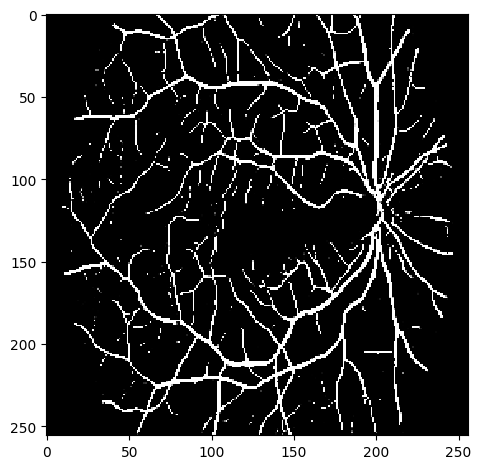

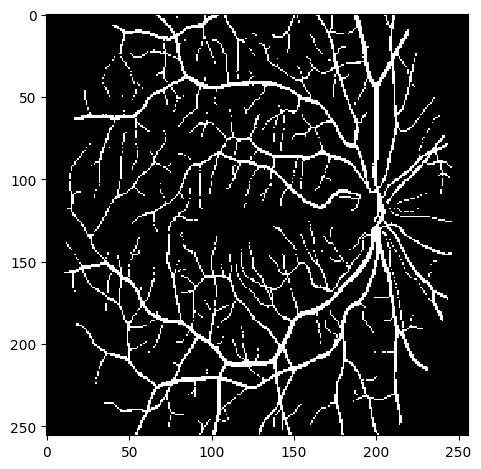

In [32]:
Y_pred = model.predict(X_test)
imshow(Y_pred[11])
plt.show()
imshow(Y_test[11])
plt.show()

In [33]:
results = model.evaluate(X_train, Y_train, verbose=1)
print(results)

3/3 [==============================] - 1s 216ms/step - loss: 0.0674 - dice_coef: 0.9108 - iou: 0.8398 - accuracy: 0.0645 - recall_1: 0.8976 - precision_1: 0.9691
[0.06743434071540833, 0.9108214378356934, 0.8398310542106628, 0.06446106731891632, 0.8976024985313416, 0.9690805077552795]


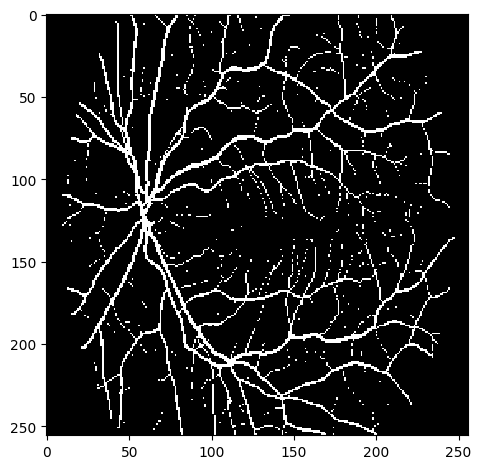

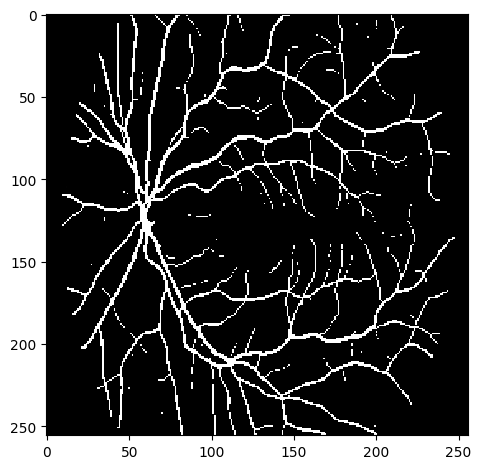

In [34]:
# from tensorflow import keras

# def get_model(model_name, compile = False):
#     return keras.models.load_model(model_name, compile=False)

# model = get_model('vggwithoutaugment.h5', False)
X = np.zeros((1, width, height, channels))
X[0] = X_train[0]
Y_pred = model.predict(X)
imshow(Y_train[0])
plt.show()
imshow(Y_pred[0])
plt.show()

In [19]:
%load_ext tensorboard
%tensorboard --logdir={'logs'}

Reusing TensorBoard on port 6006 (pid 6956), started 17:38:19 ago. (Use '!kill 6956' to kill it.)